# Data Exploration

In [ ]:
import pandas as pd
import numpy as np

In [31]:
df = pd.read_excel('data/SnP futures intraday.xlsx')
df = df.rename(columns={'Time at end of bar': 'DATE', 'OPEN': 'OPEN', 'HIGH': 'HIGH',
                       'LOW': 'LOW', 'CLOSE': 'CLOSE', 'VOLUME': 'VOLUME'})
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE').reset_index(drop=True)

print(df.head())
print(df.info())
print(df.describe()) 

                 DATE     OPEN     HIGH      LOW    CLOSE  VOLUME
0 2024-12-11 18:00:00  6087.50  6087.75  6086.50  6086.75     513
1 2024-12-11 18:01:00  6086.75  6087.00  6085.25  6085.50     366
2 2024-12-11 18:02:00  6085.50  6087.25  6085.50  6087.00     239
3 2024-12-11 18:03:00  6087.00  6087.50  6087.00  6087.25      80
4 2024-12-11 18:04:00  6087.00  6087.50  6087.00  6087.25     124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185880 entries, 0 to 185879
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATE    185880 non-null  datetime64[ns]
 1   OPEN    185880 non-null  float64       
 2   HIGH    185880 non-null  float64       
 3   LOW     185880 non-null  float64       
 4   CLOSE   185880 non-null  float64       
 5   VOLUME  185880 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 8.5 MB
None
                                DATE           OPEN         

In [32]:
print(df.isna().sum())
print(df.isnull().sum())

DATE      0
OPEN      0
HIGH      0
LOW       0
CLOSE     0
VOLUME    0
dtype: int64
DATE      0
OPEN      0
HIGH      0
LOW       0
CLOSE     0
VOLUME    0
dtype: int64


In [16]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity_adf(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:  # Common significance level
        print("Series is likely stationary (reject null hypothesis of unit root)")
    else:
        print("Series is likely non-stationary (fail to reject null hypothesis of unit root)")

print(check_stationarity_adf(df['CLOSE']))

ADF Statistic: -1.8561991017856754
p-value: 0.3529384588552401
Critical Values:
	1%: -3.4303851954787663
	5%: -2.8615555559293706
	10%: -2.5667782798630707
Series is likely non-stationary (fail to reject null hypothesis of unit root)
None


 Generate the the following indicators to feed into the model:
1. MACD (8,16,5)
2. RSI (10d)
3. Bollinger Bands (20d, 2s.d.)
4. Distilbert Sentiment Score
5. KNN Sentiment Score
6. Linear SVC Sentiment Score
7. VADER Sentiment Score

In [8]:
# Calculate MACD (8, 16, 5)
short_ema = df['CLOSE'].ewm(span=8, adjust=False).mean()
long_ema = df['CLOSE'].ewm(span=16, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['MACD_Signal'] = df['MACD'].ewm(span=5, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

In [9]:
# Calculate RSI (10 period)
delta = df['CLOSE'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=10).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=10).mean()
rs = gain / loss
df['RSI_10'] = 100 - (100 / (1 + rs))

In [11]:
# Calculate Bollinger Bands (20 period, 2 standard deviations)
df['BB_Middle'] = df['CLOSE'].rolling(window=20).mean()
df['BB_Std'] = df['CLOSE'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
df['BB_Lower'] = df['BB_Middle'] - 2

c:\Users\Jay Tai\Documents\BacktestingLSTM\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


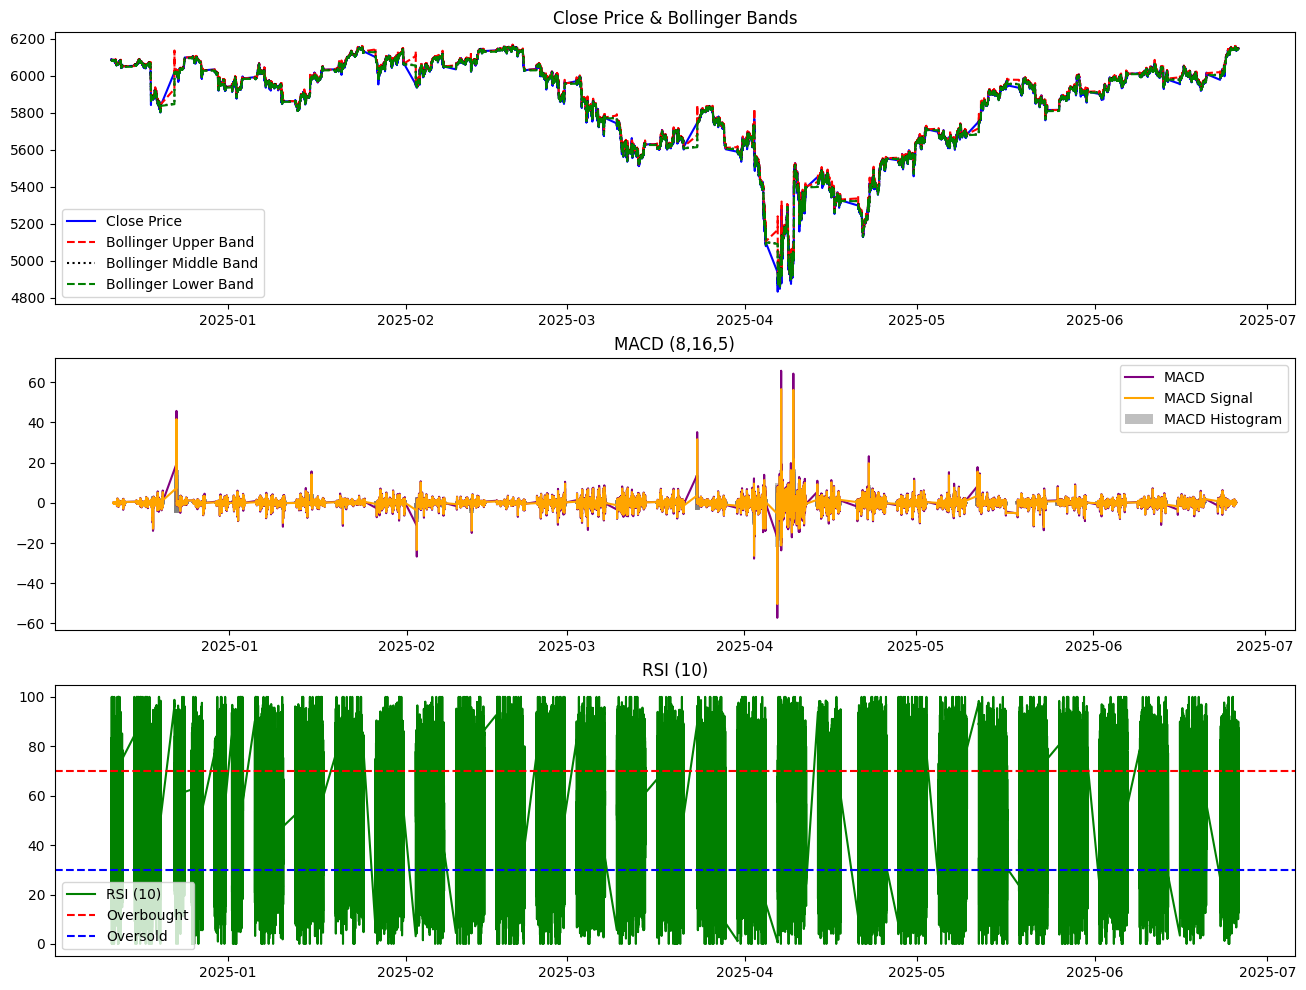

In [15]:
# plotting the indicators

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))

# 1. Closing Price with Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(df['DATE'], df['CLOSE'], label='Close Price', color='blue')
plt.plot(df['DATE'], df['BB_Upper'], label='Bollinger Upper Band', color='red', linestyle='--')
plt.plot(df['DATE'], df['BB_Middle'], label='Bollinger Middle Band', color='black', linestyle=':')
plt.plot(df['DATE'], df['BB_Lower'], label='Bollinger Lower Band', color='green', linestyle='--')
plt.title('Close Price & Bollinger Bands')
plt.legend()

# 2. MACD
plt.subplot(3, 1, 2)
plt.plot(df['DATE'], df['MACD'], label='MACD', color='purple')
plt.plot(df['DATE'], df['MACD_Signal'], label='MACD Signal', color='orange')
plt.bar(df['DATE'], df['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)
plt.title('MACD (8,16,5)')
plt.legend()

# 3. RSI
plt.subplot(3, 1, 3)
plt.plot(df['DATE'], df['RSI_10'], label='RSI (10)', color='green')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='blue', linestyle='--', label='Oversold')
plt.title('RSI (10)')
plt.legend()